In [87]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(tmpRpkg)
})
Sys.setenv("_R_USE_PIPEBIND_" = TRUE)
# change the size of figures shown in jupyter
options(repr.plot.width=10, repr.plot.height=8)

In [92]:
# * meta
projd <- here::here()
binSize <- 5000
genomeBind <- file.path(projd, "09.epimem", "out", "genomeBin")
suffix <- paste(paste(hs, collapse = "_"), binSize, sep = ".")

In [93]:
blfnm <- file.path(projd, "meta", "mm10-blacklist.v2.bed")
blGR <- loadGRfromBed(bedFile = blfnm, header = FALSE,
                     colnms = c("chr", "start", "end", "note"))

In [90]:
str(blGR)

Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 21 levels "chr10","chr11",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. ..@ lengths        : int [1:21] 297 157 200 82 200 274 156 41 226 120 ...
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. ..@ start          : int [1:3435] 0 3218900 3576900 4191100 4613500 4761300 5080800 5580100 6281200 6740200 ...
  .. .. ..@ width          : int [1:3435] 3135401 57701 50801 6501 1901 2601 15801 6501 5501 1901 ...
  .. .. ..@ NAMES          : NULL
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. ..@ lengths        : int 3

In [ ]:
# * main

In [94]:
sc <- "326_OPC_NN"
r <- data.table::fread(
    file = file.path(genomeBind, str_glue("{sc}.{suffix}.csv")),
    sep = ",", head = TRUE, data.table = FALSE)

In [95]:
str(r)

'data.frame':	545114 obs. of  3 variables:
 $ region  : chr  "chr1:1-5000" "chr1:5001-10000" "chr1:10001-15000" "chr1:15001-20000" ...
 $ H3K4me1 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ H3K27me3: num  0 0 0 0 0 0 0 0 0 0 ...


# filter regions.
1. Only autosome
2. remove signals that very low on both modifications.
3. remove blacklist regions
4. set cap for modifications
5. scale

In [96]:
r <- r[grepl("^chr[1-9]+", r$region), ]

In [97]:
quantile(with(r, H3K4me1[H3K4me1 > 0]))
quantile(with(r, H3K27me3[H3K27me3 > 0]))

0%          25%          50%          75%         100% 
8.391097e-04 1.762978e-01 3.982636e-01 9.865562e-01 3.885011e+01

0%          25%          50%          75%         100% 
9.866551e-04 3.507405e-01 6.156526e-01 1.021477e+00 7.087000e+01

In [98]:
low_H3K4me1 <- quantile(with(r, H3K4me1[H3K4me1 > 0 ]), 0.005)
low_H3K27me3 <- quantile(with(r, H3K27me3[H3K27me3 > 0]), 0.005)

In [99]:
low_H3K4me1
low_H3K27me3

0.5% 
0.008475849

0.5% 
0.01395268

In [100]:
r <- r[(r$H3K4me1 >= low_H3K4me1) & (r$H3K27me3 >= low_H3K27me3), ]

In [101]:
rownames(r) <- r$region
str(r)

'data.frame':	471931 obs. of  3 variables:
 $ region  : chr  "chr1:3000001-3005000" "chr1:3005001-3010000" "chr1:3010001-3015000" "chr1:3015001-3020000" ...
 $ H3K4me1 : num  0.1178 0.1305 0.2661 0.033 0.0898 ...
 $ H3K27me3: num  0.627 0.622 0.635 0.182 0.606 ...


In [ ]:
# Now remove blacklist overlaped region

In [102]:
genomeBins <- vapply(r$region, \(rg) {
    str_split_1(rg, ":|-")
}, c("chr1", "1", "2"))

In [103]:
str(genomeBins)

 chr [1:3, 1:471931] "chr1" "3000001" "3005000" "chr1" "3005001" "3010000" ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:471931] "chr1:3000001-3005000" "chr1:3005001-3010000" "chr1:3010001-3015000" "chr1:3015001-3020000" ...


In [104]:
genomeBins <- t(genomeBins) |> as.data.frame() |> 
   setNames(object = _, nm = c("chr", "startFrom", "endTo"))

In [105]:
genomeBins$startFrom <- as.integer(genomeBins$start)
genomeBins$endTo <- as.integer(genomeBins$endTo)
str(genomeBins)

'data.frame':	471931 obs. of  3 variables:
 $ chr      : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ startFrom: int  3000001 3005001 3010001 3015001 3020001 3025001 3030001 3035001 3040001 3045001 ...
 $ endTo    : int  3005000 3010000 3015000 3020000 3025000 3030000 3035000 3040000 3045000 3050000 ...


In [106]:
genomeBins$name <- r$region
gGR <- loadGRfromBed(beds = genomeBins, header = TRUE)
str(gGR)

Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 19 levels "chr1","chr2",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. ..@ lengths        : int [1:19] 38165 35064 31041 29695 28940 28989 26713 24919 24104 25215 ...
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. ..@ start          : int [1:471931] 3000001 3005001 3010001 3015001 3020001 3025001 3030001 3035001 3040001 3045001 ...
  .. .. ..@ width          : int [1:471931] 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 ...
  .. .. ..@ NAMES          : NULL
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. ..

In [107]:
# this will find the regions overlapped with blGR
regionInBl <- tmpRpkg::filterByGR(gGR, blGR)
str(regionInBl)

Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 19 levels "chr1","chr2",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. ..@ lengths        : int [1:19] 370 1989 1600 444 145 904 1016 251 1223 1282 ...
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. ..@ start          : int [1:16525] 8625001 8630001 8635001 8640001 8645001 8650001 8655001 8660001 8665001 8670001 ...
  .. .. ..@ width          : int [1:16525] 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 ...
  .. .. ..@ NAMES          : NULL
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. ..@ lengths        

In [108]:
str(regionInBl$name)

 chr [1:16525] "chr1:8625001-8630000" "chr1:8630001-8635000" ...


In [109]:
r <- r[!(r$region %in% regionInBl$name), ]

In [110]:
str(r)

'data.frame':	455406 obs. of  3 variables:
 $ region  : chr  "chr1:3000001-3005000" "chr1:3005001-3010000" "chr1:3010001-3015000" "chr1:3015001-3020000" ...
 $ H3K4me1 : num  0.1178 0.1305 0.2661 0.033 0.0898 ...
 $ H3K27me3: num  0.627 0.622 0.635 0.182 0.606 ...


In [49]:
quantile(r$H3K4me1)
quantile(r$H3K27me3)

0%          25%          50%          75%         100% 
 0.008475849  0.188070790  0.416656299  1.018092385 13.755069841

0%         25%         50%         75%        100% 
 0.01395268  0.36645720  0.63080112  1.03929617 14.83028548

In [53]:
cap_H3K4me1 <- quantile(r$H3K4me1, 0.999)
cap_H3K27me3 <- quantile(r$H3K27me3, 0.999)

In [54]:
cap_H3K4me1
cap_H3K27me3

99.9% 
7.921023

99.9% 
6.656958

In [56]:
# place cap for modifications
r$H3K4me1[r$H3K4me1 >= cap_H3K4me1] <- cap_H3K4me1
r$H3K27me3[r$H3K27me3 >= cap_H3K27me3] <- cap_H3K27me3

In [111]:
scaled_H3K4me1 <- scale(r$H3K4me1, center = TRUE, scale = TRUE)[, 1]
str(scaled_H3K4me1)

 num [1:455406] -0.665 -0.653 -0.528 -0.743 -0.69 ...


In [112]:
scaled_H3K27me3 <- scale(r$H3K27me3, center = TRUE, scale = TRUE)[, 1]
str(scaled_H3K27me3)

 num [1:455406] -0.267 -0.274 -0.256 -0.871 -0.296 ...


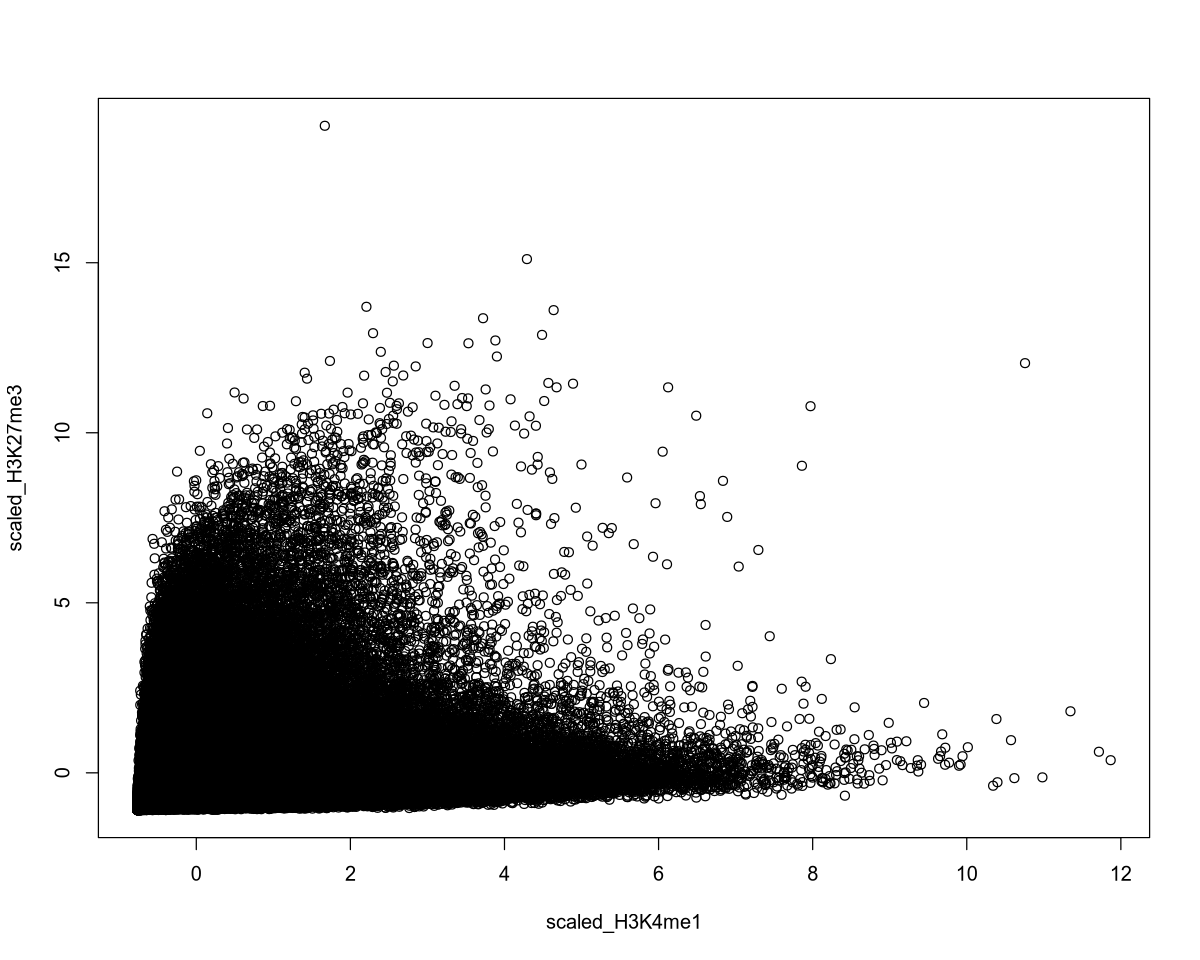

In [113]:
plot(scaled_H3K4me1, scaled_H3K27me3)

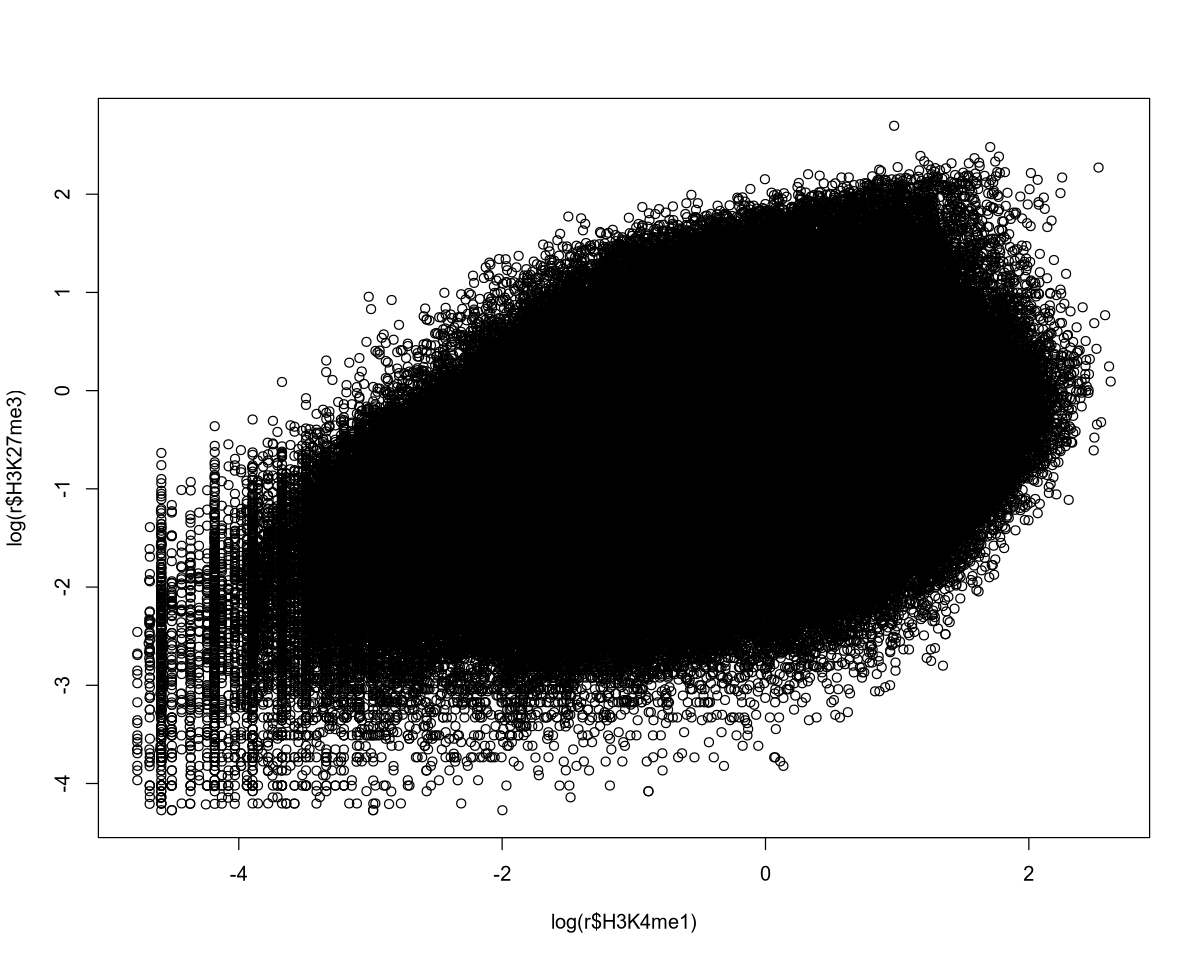

In [114]:
plot(log(r$H3K4me1), log(r$H3K27me3))

In [115]:
logscaled_H3K4me1 <- scale(log(r$H3K4me1))[, 1]
logscaled_H3K27me3 <- scale(log(r$H3K27me3))[, 1]

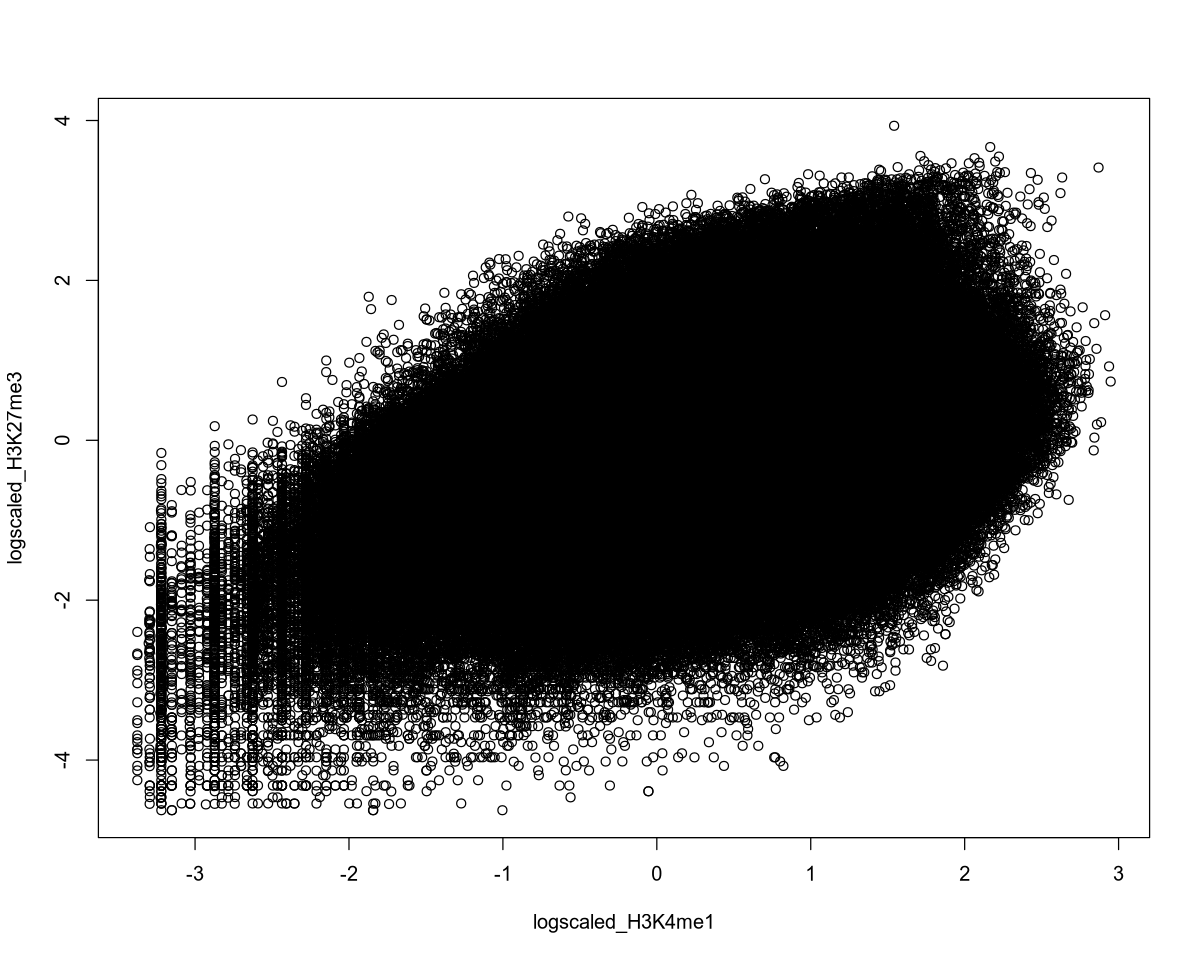

In [116]:
plot(logscaled_H3K4me1, logscaled_H3K27me3)

In [117]:
r$scaled_H3K4me1 <- scaled_H3K4me1
r$scaled_H3K27me3 <- scaled_H3K27me3

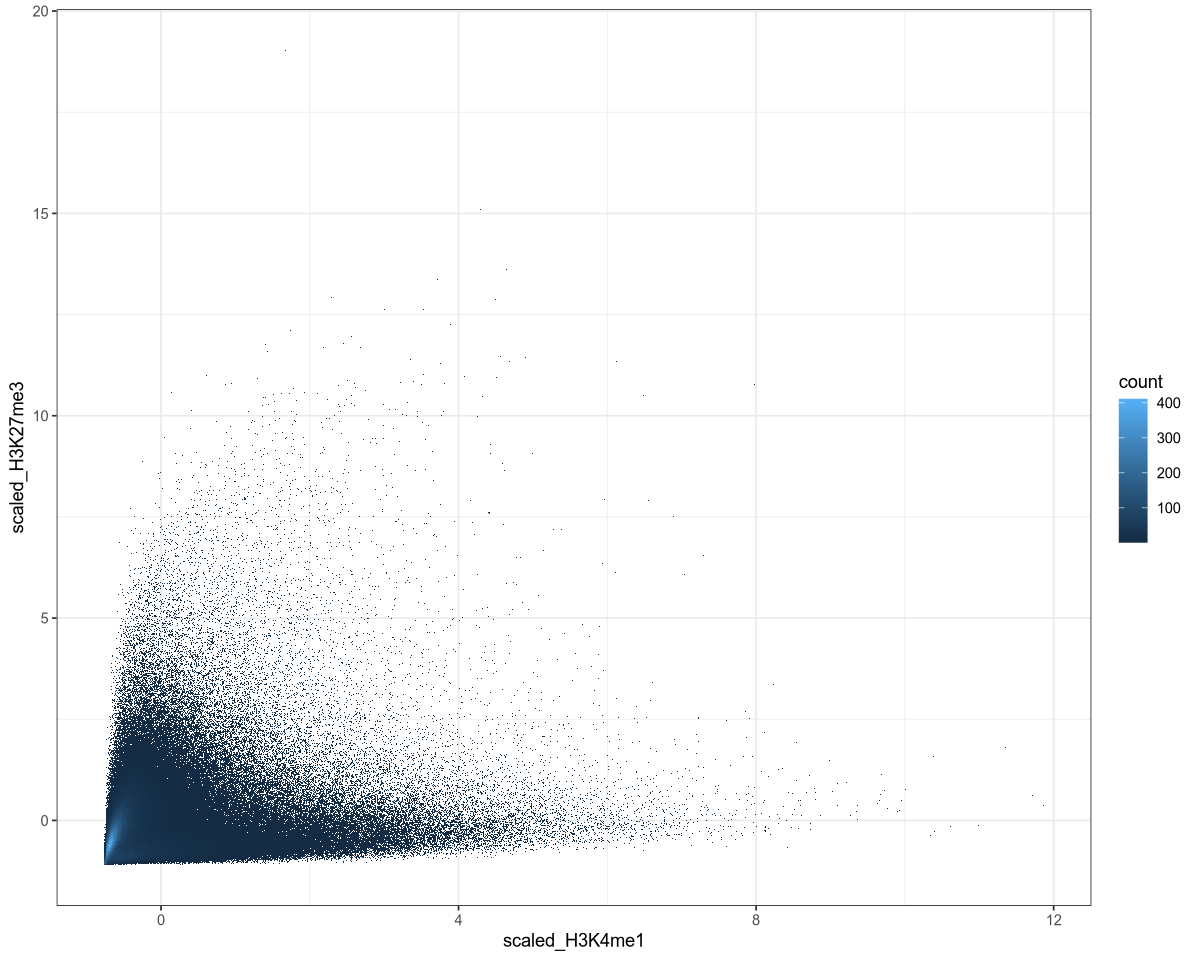

In [120]:
ggplot(data = r, aes(x = scaled_H3K4me1, y = scaled_H3K27me3)) +
    geom_bin2d(bins = 1000) +
  theme_bw()

In [121]:
r2 <- r[ (r$scaled_H3K4me1 >= 0) & (r$scaled_H3K27me3 >= 0), ]

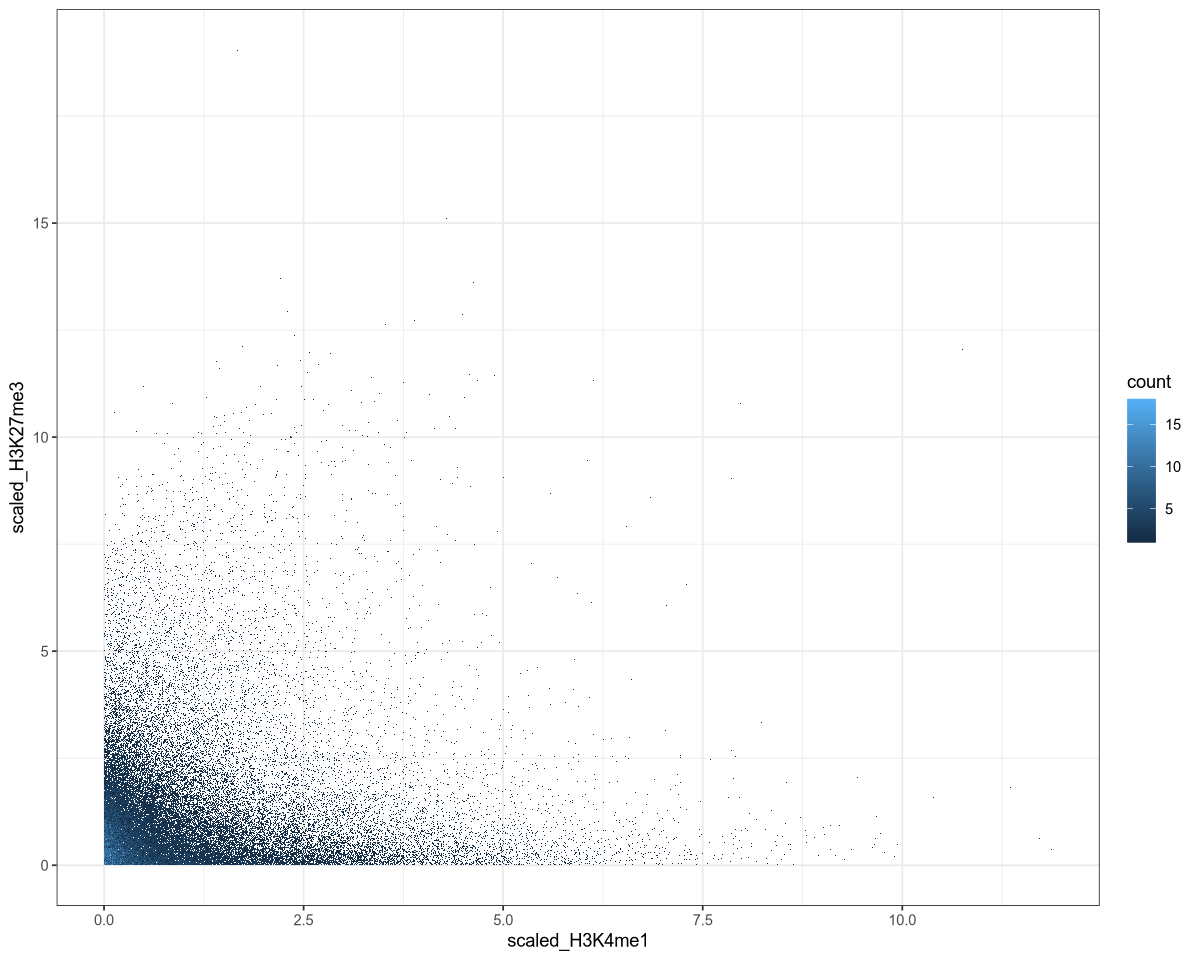

In [122]:
ggplot(data = r2, aes(x = scaled_H3K4me1, y = scaled_H3K27me3)) +
    geom_bin2d(bins = 1000) +
  theme_bw()

In [125]:
(m_H3K27me3 <- mean(r$H3K27me3))
(sd_H3K27me3 <- sd(r$H3K27me3))
(m_H3K4m1 <- mean(r$H3K4me1))
(sd_H3K4m1 <- sd(r$H3K4me1))

[1] 0.8235143

[1] 0.7361419

[1] 0.8411739

[1] 1.088147

In [127]:
high_region <- with(r, region[ (H3K27me3 >= (m_H3K27me3 + sd_H3K27me3)) & (H3K4me1 >= (m_H3K4m1 + sd_H3K4m1)) ])
str(high_region)

 chr [1:8861] "chr1:3670001-3675000" "chr1:4490001-4495000" ...


In [130]:
data.table::fwrite(r[high_region, ], file = file.path(genomeBind, str_glue("{sc}.meanplus1sd.H3K4me1-H3K27me3.csv")), 
                  sep = ",")

In [69]:
# Add H3K27ac epi signals
r27 <- data.table::fread(
    file = file.path(genomeBind, str_glue("{sc}.H3K27ac.{binSize}.csv")),
    sep = ",", head = TRUE, data.table = FALSE)
rownames(r27) <- r27$region

In [70]:
str(r27)

'data.frame':	545114 obs. of  2 variables:
 $ region : chr  "chr1:1-5000" "chr1:5001-10000" "chr1:10001-15000" "chr1:15001-20000" ...
 $ H3K27ac: num  0 0 0 0 0 0 0 0 0 0 ...


In [76]:
r27 <- r27[r27$region %in% r$region, ]
str(r27)
r27 <- r27[r$region, ]

'data.frame':	455406 obs. of  2 variables:
 $ region : chr  "chr1:3000001-3005000" "chr1:3005001-3010000" "chr1:3010001-3015000" "chr1:3015001-3020000" ...
 $ H3K27ac: num  0.1464 0.1708 0.1708 0.0629 0.1565 ...


In [74]:
quantile(r27$H3K27ac)
quantile(r27$H3K27ac, 0.999)

0%        25%        50%        75%       100% 
 0.0000000  0.1788937  0.4308899  0.9572233 23.2697126

99.9% 
11.27393

In [75]:
r27$H3K27ac[r27$H3K27ac >= quantile(r27$H3K27ac, 0.999)] <- quantile(r27$H3K27ac, 0.999)

In [78]:
r27$scaled_H3K27ac <- scale(r27$H3K27ac)
r27$logscaled_H3K27ac <- scale(log(r27$H3K27ac))

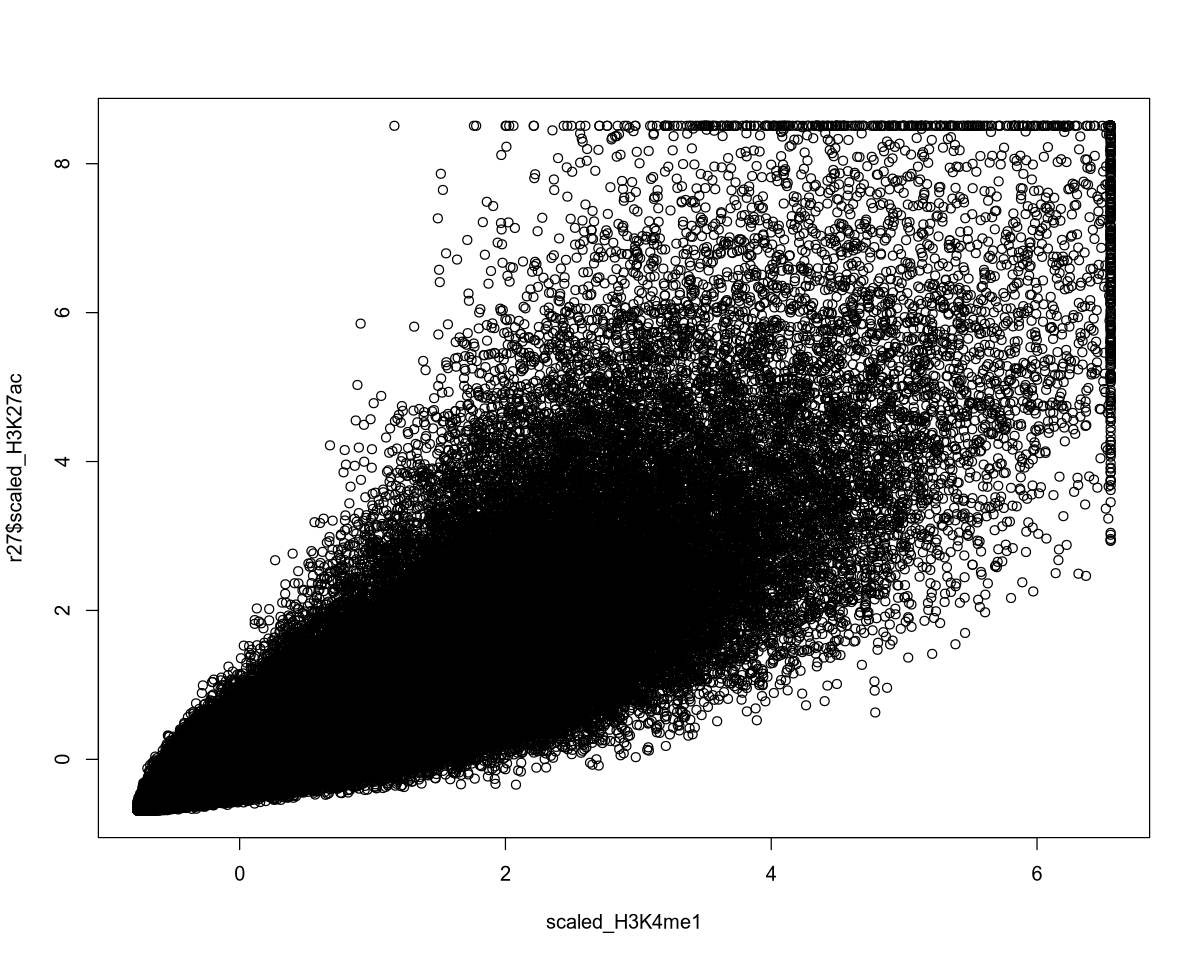

In [80]:
plot(scaled_H3K4me1, r27$scaled_H3K27ac)

In [85]:
r27$logscaled_H3K27ac <- scale(log(r27$H3K27ac + 0.000001))
str(r27$logscaled_H3K27ac)

 num [1:455406, 1] -0.611 -0.514 -0.514 -1.148 -0.569 ...
 - attr(*, "scaled:center")= num -0.959
 - attr(*, "scaled:scale")= num 1.57


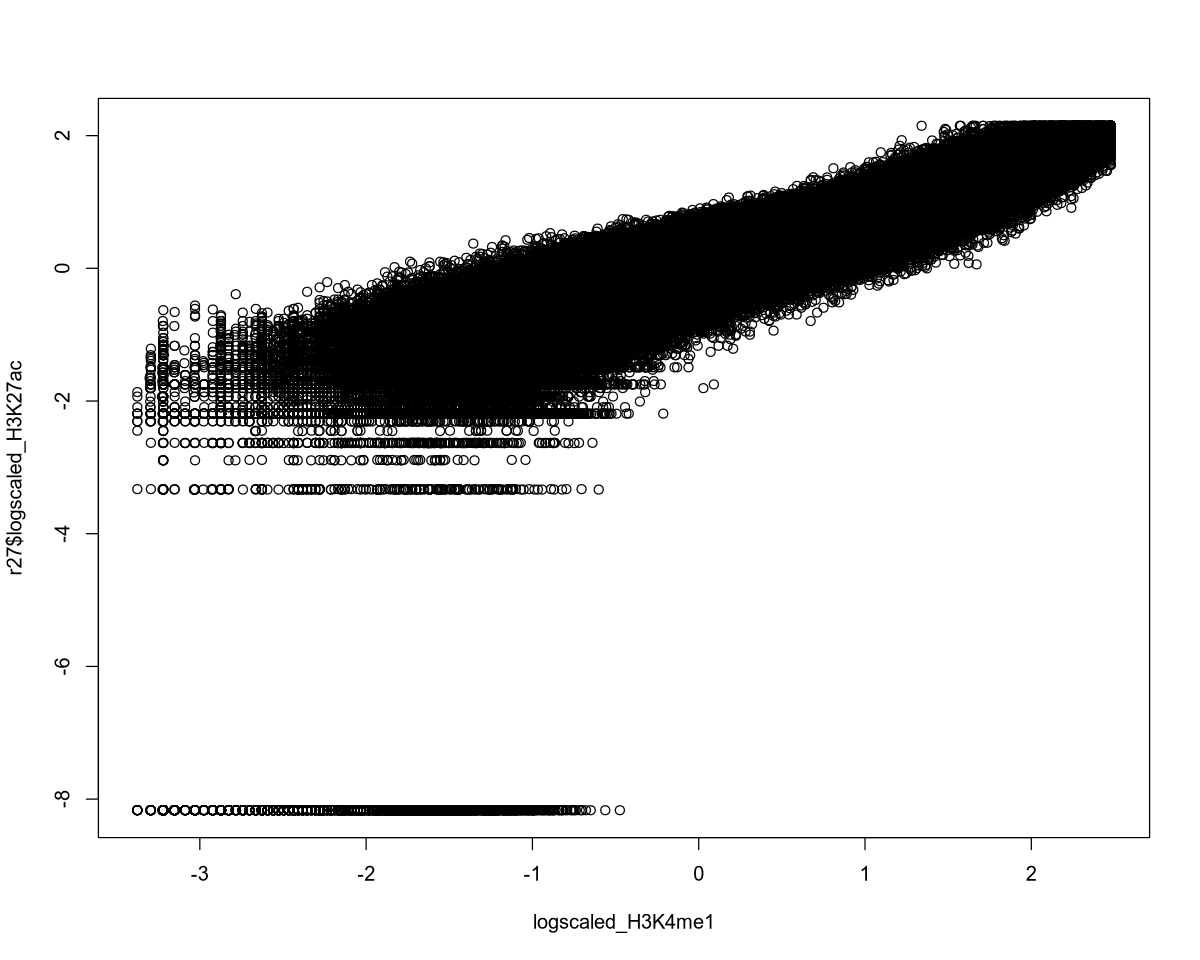

In [86]:
plot(logscaled_H3K4me1, r27$logscaled_H3K27ac)